In [1]:
import sys
sys.path.append('./automl')
from automl.aml_main import auto_lightgbm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

X, y = make_classification(n_samples=2000,n_features=30,n_classes=2,random_state=328)
data = pd.DataFrame(X)
data['bad_ind'] = y
data['imei'] = [i for i in range(len(data))]
data.columns = ['f0_radius','f0_texture','f0_perimeter','f0_area','f0_smoothness',
                'f0_compactness','f0_concavity','f0_concave_points','f0_symmetry',
                'f0_fractal_dimension','f1_radius_error','f1_texture_error','f1_perimeter_error',
                'f2_area_error','f2_smoothness_error','f2_compactness_error','f2_concavity_error',
                'f2_concave_points_error','f2_symmetry_error','f2_fractal_dimension_error',
                'f3_radius','f3_texture','f3_perimeter','f3_area','f3_smoothness',
                'f3_compactness','f3_concavity','f3_concave_points','f3_symmetry',
                'f3_fractal_dimension','bad_ind','imei']

dev, off = train_test_split(data, test_size=0.3, random_state=328)

uid, dep = "imei", "bad_ind"
var_names = list(data.columns)
var_names.remove(dep)

datasets = {"dev": dev, "off": off}

lgb_base = auto_lightgbm(datasets, dep, var_names, uid, params={'num_threads': 32}, early_stopping_rounds=10)

/home/shugang.sg/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
#IV计算，数据源评价,数据探索性分析，对数据有固定格式要求，后续操作不依赖该过程，通常跳过
pre_analyze_result = lgb_base.pre_analyze(evl_source=True, #数据源评估
                                          detect=True,     #数据探索性分析
                                          cpu_cores=32)     #核的数量

pre_analyze_result.keys()

100%|██████████| 30/30 [00:00<00:00, 379.90it/s]

IV 计算完成 	
--------------------------------------------------


数据源评价完成，共计 4 个数据源 	
--------------------------------------------------


dict_keys(['IV', 'source_evl', 'detect'])

In [3]:
#训练模型
model,new_var_names = lgb_base.train(select_feature=True, #特征筛选
                                     select_type='shap',  #特征筛选指标
                                     single_delete=True,  #逐个特征删除
                                     imp_threhold=0,      #特征筛选指标阈值
                                     corr_threhold=0.7,   #相关系数阈值
                                     psi_threhold=0.1,    #PSI阈值
                                     target='weight',     #参数搜索目标函数
                                     params_weight=0.5,   #weight目标函数权重              
                                     reduce_memorey=False) #优化DataFrame内存

开始自动建模...
--------------------------------------------------
Shap阈值 0
shap删除特征个数： 26 shap保留特征个数： 4
--------------------------------------------------
相关性阈值: 0.7 相关性删除特征个数： 2 相关性保留特征个数： 2
--------------------------------------------------
PSI阈值 0.1
PSI删除特征个数： 0 PSI保留特征个数： 2
--------------------------------------------------
开始参数搜索,目标函数 weight
train_number: 0, devks: 0.7838767284045104, offks: 0.7275395837039672, params: {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'reg_lambda': 3, 'reg_alpha': 0.85, 'num_leaves': 31, 'learning_rate': 0.02, 'min_data': 50, 'min_hessian': 0.05, 'num_threads': 32, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 2, 'verbose': -1, 'num_boost_round': 100}
(Good) train_number: 7, devks: 0.783070564824736, offks: 0.7277174879914605, params: {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'reg_lambda': 3, 'reg_alpha': 1.35, 'num_leaves': 31, 'learning_rate': 0.02, 'min_data': 50, 'min_hessian': 0.05, 'num_

100%|██████████| 1/1 [00:00<00:00, 51.50it/s]

--------------------------------------------------
Best params:  {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'reg_lambda': 3, 'reg_alpha': 1.85, 'num_leaves': 31, 'learning_rate': 0.01999999999999999, 'min_data': 50, 'min_hessian': 0.05000000000000002, 'num_threads': 32, 'feature_fraction': 0.9000000000000001, 'bagging_fraction': 0.7999999999999999, 'bagging_freq': 2, 'verbose': -1, 'num_boost_round': 100}
--------------------------------------------------
开始逐步删除特征 	
train_number: 0, offks: 0.7254047322540473
(Good) train_n: 2, offks: 0.7488436221312933 by vars: f3_concavity
(End) train_n: 3, offks: 0.0679149617505782 del_list_vars: ['f3_concavity']
逐步删除特征个数： 1 逐步保留特征个数： 1
--------------------------------------------------
KS & PSI:  {'devks': 0.8082351140364304, 'offks': 0.7488436221312933, 'offpsi': 0.008277303072244089}
--------------------------------------------------
AutoML建模完成


feature_importance top1:  
 {'feature': 'f0_concavity', 'importance': 15127.753057420254, 'ratio': 1.0}
shap top1:  
 {'feature': 'f0_concavity', 'shap_values': 0.8419673367905933}


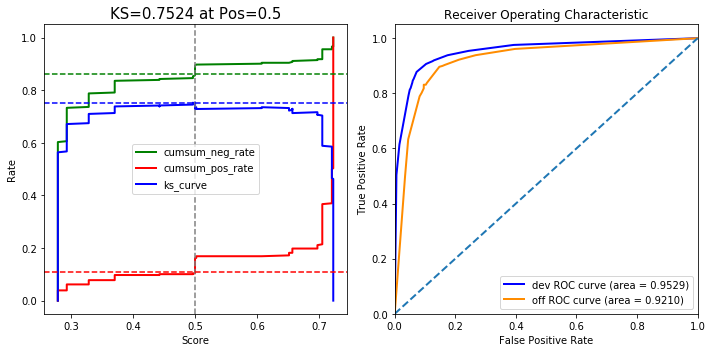

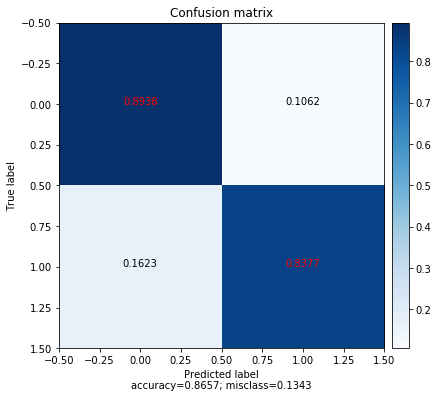

--------------------------------------------------
生成最大ks点上的分类报告
--------------------------------------------------
自动划分为 5 个等级
--------------------------------------------------
报告完成


In [4]:
#生产报告
report = lgb_base.model_summary(model,                     #模型
                                var_names = new_var_names, #入模变量名
                                ks_bins=10,                #分箱个数
                                level_num=5,               #自动分层个数
                                level_split_type='all')    #用于分层的数据集all/dev/off

In [5]:
report.keys()

dict_keys(['importance', 'bucket', 'shap', 'clf_report', 'leveldf'])

In [6]:
report['shap']

,feature,shap_values,shap_corr
0,f0_concavity,0.841967,0.895631


In [7]:
report['leveldf']

,样本量,响应占比,min,max
level,,,,
A,633,0.045814,0.000000,0.293156
B,246,0.154472,0.293156,0.370456
C,171,0.397661,0.370456,0.501981
D,304,0.809211,0.501981,0.720654
E,128,0.921875,0.720654,0.722855
F,518,0.972973,0.722855,high


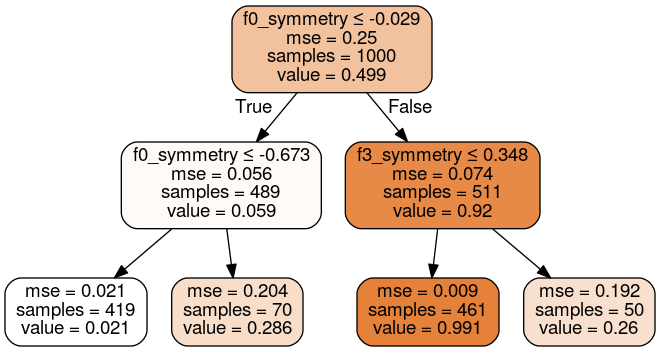

In [8]:
from sklearn.datasets import make_classification
from automl.aml_main import auto_DecisionTreeRegressor
from automl.utils.Decision_utils import DTR_TO_SQL
from IPython.display import Image

X, y = make_classification(n_samples=1000,n_features=30,n_classes=2,random_state=328)
data = pd.DataFrame(X)
data['bad_ind'] = y
data['imei'] = [i for i in range(len(data))]
data.columns = ['f0_radius','f0_texture','f0_perimeter','f0_area','f0_smoothness',
                'f0_compactness','f0_concavity','f0_concave_points','f0_symmetry',
                'f0_fractal_dimension','f1_radius_error','f1_texture_error','f1_perimeter_error',
                'f2_area_error','f2_smoothness_error','f2_compactness_error','f2_concavity_error',
                'f2_concave_points_error','f2_symmetry_error','f2_fractal_dimension_error',
                'f3_radius','f3_texture','f3_perimeter','f3_area','f3_smoothness',
                'f3_compactness','f3_concavity','f3_concave_points','f3_symmetry',
                'f3_fractal_dimension','bad_ind','imei']


uid, dep = "imei", "bad_ind"
var_names = list(data.columns)
var_names.remove(dep)
var_names.remove(uid)

#指定不参与建模的变量，包含标签bad_ind。
ex_lis = [uid, dep]

#调用决策树函数
dct = auto_DecisionTreeRegressor(datasets = data,ex_lis = ex_lis,is_bin=False,
                                 dep = dep,min_samples=0.01,max_depth=2,
                                 min_samples_leaf=50,min_samples_split=50).fit_plot()
#展示图像
Image(dct['graph'])

In [9]:
#获取SQL，决策树模型/变量名/when_else异常赋值默认为-1
DTR_TO_SQL(dct['dtree'],dct['feature_names'],when_else=0)

case 
 when f0_symmetry<=-0.028780914843082428 and f0_symmetry<=-0.6725731492042542  then 0.021479713603818614
 when f0_symmetry<=-0.028780914843082428 and f0_symmetry>-0.6725731492042542  then 0.2857142857142857
 when f0_symmetry>-0.028780914843082428 and f3_symmetry<=0.34790952503681183  then 0.9913232104121475
 when f0_symmetry>-0.028780914843082428 and f3_symmetry>0.34790952503681183  then 0.26
else 0 end as clusters
